In [1]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [51]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 32

# Training 수
epochs = 30

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

# Deep learning model architecture

In [53]:
from multiprocessing.dummy import active_children


BaseModel = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)

x = GlobalAveragePooling2D()(BaseModel.output)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(3, activation='softmax')(x)

DeepLearning = Model(inputs=BaseModel.input, outputs=predictions)

# Custom Generator with flow from directory

In [54]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, Generator, directory, target_size, batch_size, shuffle, class_mode, subset=None):
        self.GeneratorObject = Generator.flow_from_directory(
                directory = directory,
                target_size = target_size,
                batch_size = batch_size,
                shuffle = shuffle,
                class_mode = class_mode,
                subset = subset)
        self.n = self.GeneratorObject.n
        self.batch_size = batch_size
        self.classes = self.GeneratorObject.classes
        self.filenames = self.GeneratorObject.filenames
        self.round = cv2.resize(np.array(PIL.Image.open("Round.jpg").convert("RGB")),(img_width, img_height))
    def __len__(self):
        return self.GeneratorObject.__len__()

    def __getitem__(self, index):
        Images, Labels = self.GeneratorObject.__getitem__(index)
        Images = np.array([Images[i][:,:,] * (self.round[:,:,]/255) for i in range(0, len(Labels))])
        return Images, Labels
    
    def next(self):
        Images, Labels = self.GeneratorObject.next()
        Images = np.array([Images[i][:,:,] * (self.round[:,:,]/255) for i in range(0, len(Labels))])
        return Images, Labels
    
    def on_epoch_end(self):
        return self.GeneratorObject.on_epoch_end()

In [55]:
DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [56]:
TRAIN_GENERATOR = DataGenerator(DATAGEN_TRAIN,
    './TRAIN',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = True,
    subset='training')

VALID_GENERATOR = DataGenerator(DATAGEN_TRAIN,
    './TRAIN',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = True,
    subset='validation')

TEST_GENERATOR = DataGenerator(DATAGEN_TEST,
    './TEST',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='training')

Found 719 images belonging to 3 classes.
Found 79 images belonging to 3 classes.
Found 106 images belonging to 3 classes.


c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\preprocessing\image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


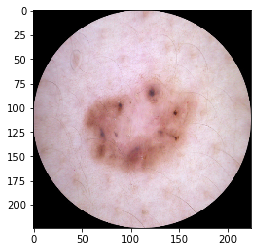

In [57]:
item = TEST_GENERATOR.__getitem__(2)
plt.imshow(item[0][0], interpolation='nearest')
plt.show()

In [59]:
# Call-back 함수

tensorboard_directory = './TTensorboard'

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='./MODEL/7th/{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# 학습과정 진행사항 확인
# TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, LR]

In [61]:
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
) # 나이를, MSE


with tf.device("/device:GPU:0"):
        DeepLearning.fit_generator(
                TRAIN_GENERATOR,
                # steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
                epochs=epochs,
                callbacks=CALLBACK,
                shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
                validation_data=VALID_GENERATOR)


c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
C:\Users\gmlkd\AppData\Local\Temp\ipykernel_24524\2709834272.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  DeepLearning.fit_generator(
c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\preprocessing\image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit i

Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.0743 - acc: 0.4270
Epoch 1: val_acc improved from -inf to 0.41772, saving model to ./MODEL/7th\001-1.0160-0.4177.hdf5
23/23 [==============================] - 12s 473ms/step - loss: 1.0743 - acc: 0.4270 - val_loss: 1.0160 - val_acc: 0.4177 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.0895 - acc: 0.4729
Epoch 2: val_acc did not improve from 0.41772
23/23 [==============================] - 11s 449ms/step - loss: 1.0895 - acc: 0.4729 - val_loss: 1.1041 - val_acc: 0.3418 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1147 - acc: 0.3574
Epoch 3: val_acc did not improve from 0.41772
23/23 [==============================] - 10s 448ms/step - loss: 1.1147 - acc: 0.3574 - val_loss: 1.1030 - val_acc: 0.3165 - lr: 0.0010
Epoch 4/30
23/23 [==============================] - ETA: 0s - loss: 1.1038 - acc: 0.3296
Epoch 4: val_acc did not improve from 0.41772

E

In [63]:
DeepLearning.load_weights('./MODEL/7th/025-0.7389-0.7595.hdf5')

In [64]:
prediction = DeepLearning.predict(TEST_GENERATOR)

c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\preprocessing\image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


4/4 [==============================] - 2s 417ms/step


In [81]:
prediction[-1]

array([0.11653492, 0.23027849, 0.65318656], dtype=float32)